# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the navigation task. This task has been taken from Udacity-Deep-Reinforcement-Learning Nanodegree. The algorithm you will be implementing is **REINFORCE** to achieve the task.

(https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name='Banana_Windows_x86_64/Banana.exe',no_graphics=True) #put path to environment file

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


In [5]:
####################

In [6]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): Total number of actions
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AgentNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, h1_size = 16, h2_size = 16):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Total number of actions
            seed (int): Random seed
        """
        super(AgentNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        "*** YOUR CODE HERE ***"
        self.fc1 = nn.Linear(state_size, h1_size)
        self.fc2 = nn.Linear(h1_size, h2_size)
        self.fc3 = nn.Linear(h2_size, action_size)

    def forward(self, state):
        """Build a network that maps state -> action probabilities."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x

In [8]:
import numpy as np
import random
from collections import namedtuple, deque

# from model import AgentNetwork
# from memory import ReplayBuffer

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e4)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Agent-Network
        ## TODO: Initialize your action network here
        "*** YOUR CODE HERE ***"
        self.network = AgentNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=LR)
        self.network.train()

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.0, get_prob = False):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.network.eval()
        with torch.no_grad():
            action_values = self.network(state)
        self.network.train()
        
        if get_prob:
            return action_values.cpu().data.numpy()
            
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def discount_rewards(self, rewards, gamma=0.99):
        r = np.array([gamma**i * rewards[i] 
                      for i in range(len(rewards))])
        # Reverse the array direction for cumsum and then
        # revert back to the original order
        r = r[::-1].cumsum()[::-1]
        return r - r.mean()
     
    def learn(self, experiences, gamma = GAMMA):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        rewards = self.discount_rewards(rewards);

        ## TODO: compute and minimize the loss using REINFORCE
        "*** YOUR CODE HERE ***"
        self.optimizer.zero_grad()
        state_tensor = torch.FloatTensor(states)
        reward_tensor = torch.FloatTensor(rewards)
        action_tensor = torch.LongTensor(actions)
        
        # Calculate loss
        logprob = torch.log(self.network.forward(state_tensor))
        selected_logprobs = reward_tensor * logprob[np.arange(len(action_tensor)), action_tensor]
        loss = -selected_logprobs.mean()
        
        # Calculate gradients
        loss.backward()
        # Apply gradients
        self.optimizer.step()
        
        
                             


### AGENT

In [9]:
# from agent import Agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [10]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state, 0)       # select an action
    action = int(action)
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

C:\Users\Arun Singh\Anaconda3\envs\unity\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Score: 0.0


When finished, you can close the environment.

In [11]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [12]:
from collections import deque
import random

In [13]:
n_episodes = 10
eps = 1.0
min_eps=0.01
max_episode_length = 100
eps_decay=0.995

In [14]:
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=20)  # last 100 scores

for i_episode in range(n_episodes):
    env_info = env.reset(train_mode=True)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0
    for t in range(max_episode_length):
        action = agent.act(state, eps)
        action = int(action)
        env_info = env.step(action)[brain_name] 
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0] 
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break 
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    eps = max(min_eps, eps_decay*eps) # decrease epsilon
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(1+i_episode, score), end="")
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(1+i_episode, np.mean(scores_window)), end="")
    if i_episode % 10 == 0 and i_episode:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(1+i_episode, np.mean(scores_window)))
    if np.mean(scores_window)>=13.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(1+i_episode-100, np.mean(scores_window)))
        torch.save(agent.network.state_dict(), 'reinforce_banana.pth')
        break

C:\Users\Arun Singh\Anaconda3\envs\unity\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 10	Average Score: 0.20

### Plot the results

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

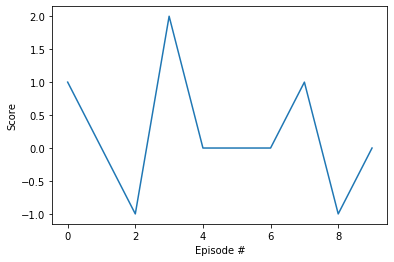

In [16]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [17]:
# load the weights from file
#agent.network.load_state_dict(torch.load('reinforce_banana.pth'))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state, 0)       # select an action
    action = int(action)
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

C:\Users\Arun Singh\Anaconda3\envs\unity\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Score: 0.0


In [18]:
# env.close()